### Setup

In [1]:
using Pkg

# Pkg.add(url="https://github.com/mppmu/BoostFractor.jl.git")
# Pkg.add(url="https://github.com/bergermann/Dragoon.jl.git")
Pkg.update()

    Updating registry at `C:\Users\domin\.julia\registries\General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
    Updating git-repo `https://github.com/mppmu/BoostFractor.jl.git`
   Installed ConcurrentUtilities ─ v2.4.2
   Installed Hwloc_jll ─────────── v2.11.0+0
   Installed GR_jll ────────────── v0.73.6+0
   Installed InlineStrings ─────── v1.4.1
   Installed DateFormats ───────── v0.1.19
   Installed NearestNeighbors ──── v0.4.18
   Installed StaticArrays ──────── v1.9.7
   Installed GLFW_jll ──────────── v3.4.0+0
   Installed XSLT_jll ──────────── v1.1.41+0
   Installed TranscodingStreams ── v0.10.10
   Installed Xorg_libxcb_jll ───── v1.17.0+0
   Installed XML2_jll ──────────── v2.13.1+0
   Installed CodecZlib ─────────── v0.7.5
   Installed Latexify ──────────── v0.16.4
   Installed Qt6Base_jll ───────── v6.7.1+1
   Installed BitFlags ──────────── v0.1.9
   Installed GR ────────────────── v0.73.6
   Installed UnitfulLatexify ───── v1.6.4
    Updatin

In [2]:
using Dragoon
using Plots
using HDF5
# using Dates

In [57]:
n = 8 # number of discs in the booster

initdist = findpeak1d(18.65e9,n; eps=9.35,tand=3e-5,granularity=100_000,deviation=0.4) # initial disc configuration

freqs = genFreqs(18.65e9,50e6; n=100) # optimize on these frequencies
freqsplot = genFreqs(18.65e9,500e6; n=1000) # plot with these frequencies

booster = AnalyticalBooster(initdist; ndisk=n,ϵ=9.35,tand=3e-5,R=0.1)  # physical properties of the booster

hist = initHist(booster,10000,freqs,ObjAnalytical); # stores measurements

### Optimizer

In [58]:
trace = nelderMead(booster,hist,freqs,
                    1.,1+2/booster.ndisk,0.75-1/2booster.ndisk,1-1/booster.ndisk,1e-9,
                    ObjAnalytical,
                    InitSimplexCoord(1e-4),
                    DefaultSimplexSampler,
                    UnstuckDont;
                    maxiter=Int(5e4),
                    traceevery=20,
                    showtrace=true,
                    showevery=10000,
                    unstuckisiter=true);

Iter: 10000, timestamp: 10 minutes, 15 seconds
Iter finished. Objective value: -1629.16

Iter: 20000, timestamp: 12 minutes, 8 seconds
Iter finished. Objective value: -1641.99

Iter: 30000, timestamp: 12 minutes, 47 seconds
Iter finished. Objective value: -1644.156

Iter: 40000, timestamp: 12 minutes, 59 seconds
Iter finished. Objective value: -1644.723

Iter: 50000, timestamp: 13 minutes
Iter finished. Objective value: -1644.881

Terminated. Max iterations reached.
Final objective value: -1644.881
Elapsed movement time:  13 minutes
Summed distance:   0.314
Elapsed computing time: 51 seconds, 212 milliseconds


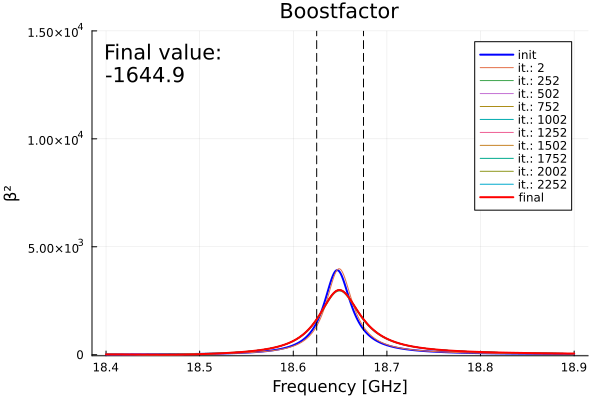

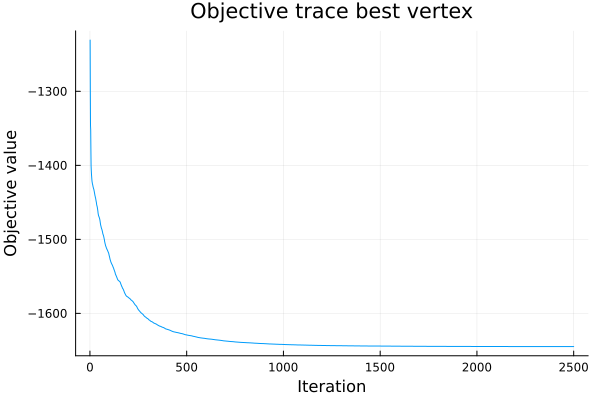

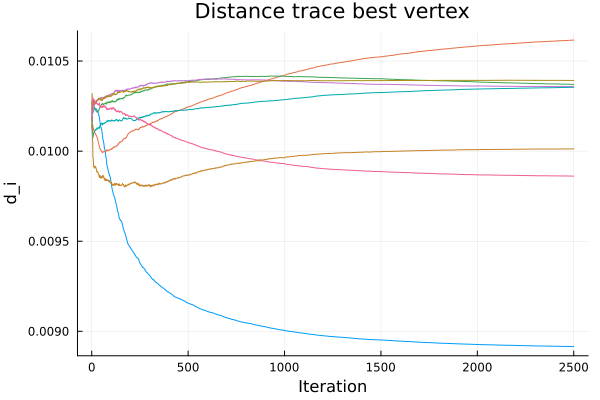

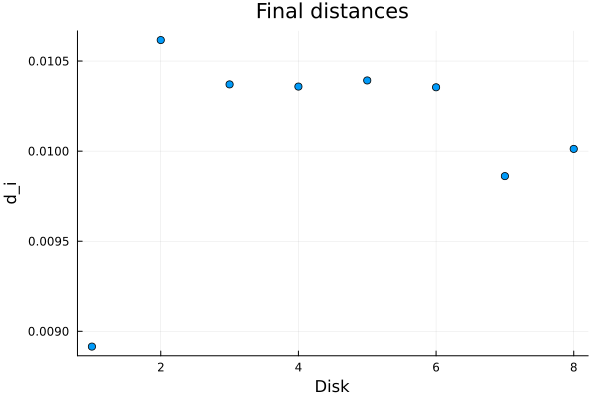

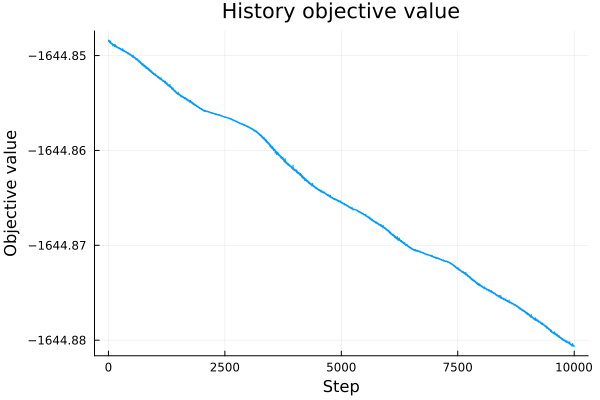

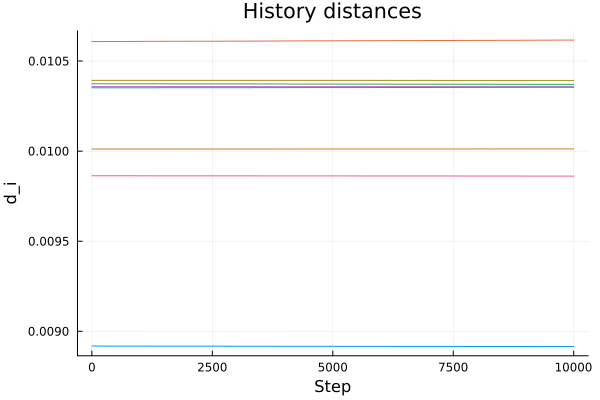

"c:\\Users\\domin\\OneDrive\\Desktop\\Julia Files\\Dragoon.jl\\examples\\final distances.svg"

In [59]:
#get handy output
trace = trace[1:end-1]
plt = analyse(booster,hist,trace,freqsplot; freqs=freqs,div=10,ylim=[-50,15000])

savefig(plt[1],"boost process.svg")
savefig(plt[3],"distance process.svg")
savefig(plt[4],"final distances.svg")

In [60]:
obj = zeros(length(trace))
dists = zeros(length(trace),booster.ndisk)
boost = zeros(length(trace),length(freqs))
ref = zeros(ComplexF64,length(trace),length(freqs))

for i in eachindex(trace)
    obj[i] = trace[i].obj[1]
    dists[i,:] = pos2dist(trace[i].x[:,1])
    boost[i,:] = boost1d(dists[i,:],freqs; eps=9.35,tand=3e-5)
    ref[i,:] = ref1d(dists[i,:],freqs; eps=9.35,tand=3e-5)
end

In [61]:
h5write("$(n)discs.h5","data/obj",obj)
h5write("$(n)discs.h5","data/dists",dists)
h5write("$(n)discs.h5","data/boost",boost)
h5write("$(n)discs.h5","data/ref",ref)
h5write("$(n)discs.h5","data/freqs",freqs)

In [22]:
N = collect(4:20)
BW = collect(5:5:100)

OBJ = zeros(Float64,length(N),length(BW))

for (i,n) in enumerate(N)
    println("ndisk: ",n)
    initdist = findpeak1d(18.65e9,n; eps=9.35,tand=3e-5,granularity=100_000,deviation=0.4) # initial disc configuration
    println("initdist: ",initdist)
    for (j,bw) in enumerate(BW)
        println("bandwidth: ",bw," MHz")

        freqs = genFreqs(18.65e9,bw*1e6; n=100) # optimize on these frequencies
        # freqsplot = genFreqs(18.65e9,bw*1e7; n=1000) # plot with these frequencies

        booster = AnalyticalBooster(initdist; ndisk=n,ϵ=9.35,tand=3e-5,R=0.1)  # physical properties of the booster

        hist = initHist(booster,10000,freqs,ObjAnalytical); # stores measurements

        trace, term = nelderMead(booster,hist,freqs,
                    1.,1+2/booster.ndisk,0.75-1/2booster.ndisk,1-1/booster.ndisk,1e-9,
                    ObjAnalytical,
                    InitSimplexCoord(1e-4),
                    DefaultSimplexSampler,
                    UnstuckDont;
                    maxiter=Int(1e3),
                    showtrace=false,
                    showevery=typemax(Int),
                    unstuckisiter=true,
                    returntimes=true);

        OBJ[i,j] = term[1]

        println("objective value: ",term[1])
    end
end

ndisk: 4
initdist: 0.009943323121315396
bandwidth: 5 MHz
objective value: -4899.704863718152
bandwidth: 10 MHz
objective value: -2845.303536908615
bandwidth: 15 MHz
objective value: -1999.7324493724311
bandwidth: 20 MHz
objective value: -1700.7681360365568
bandwidth: 25 MHz
objective value: -1393.1463693010592
bandwidth: 30 MHz
objective value: -1223.9261618926637
bandwidth: 35 MHz
objective value: -1058.094661840561
bandwidth: 40 MHz
objective value: -869.4612063400975
bandwidth: 45 MHz
objective value: -835.4484992589532
bandwidth: 50 MHz
objective value: -721.3785473515895
bandwidth: 55 MHz
objective value: -713.9717909045705
bandwidth: 60 MHz
objective value: -640.4361580513666
bandwidth: 65 MHz
objective value: -600.8605535302673
bandwidth: 70 MHz
objective value: -575.7490877557918
bandwidth: 75 MHz
objective value: -510.02041845694305
bandwidth: 80 MHz
objective value: -508.06865834272367
bandwidth: 85 MHz
objective value: -470.8000807493993
bandwidth: 90 MHz
objective value: -4

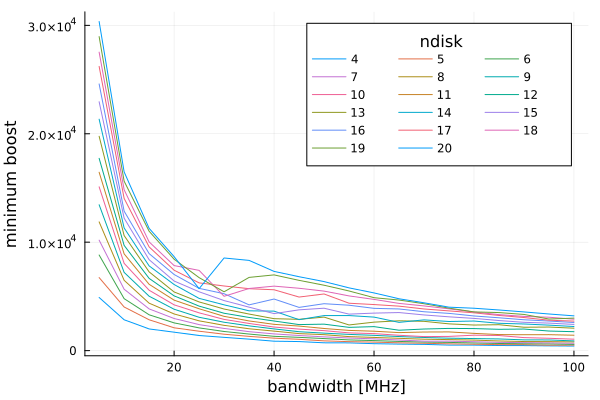

In [23]:
plot(BW,-OBJ'; label=N',legendtitle="ndisk",xlabel="bandwidth [MHz]", ylabel="minimum boost",legendcolumns=3)
# plot!(BW,1.5e4/0.2 ./BW; label="const/BW",c=:red,lw=2)